In [1]:
import numpy as np
import cv2 as cv
import sys
sys.path.insert(0, R'C:\Users\sondr\OneDrive - NTNU\KodeTesting\FinishedClass\Python')
from classes import Translation
from helpFunctions import *
def fft2d(inp):
    return np.fft.fft2(inp)

def ifft2d(inp):
    return np.abs(np.fft.ifft2(inp))


In [2]:
def gen_arrays(dim1 = (2, 2), dim2 = (4, 4)):
    d = np.zeros((5, 5), dtype=np.uint8)
    c = np.ones(5, dtype=np.uint8)
    k = d.copy()
    d[dim1[0], :] = c
    d[:,dim1[1]] = c
    k[dim2[0], :] = c
    k[:, dim2[1]] = c
    return d, k

In [3]:

def phaseCorrelation(image1, image2):
    """
    Computes the phase correlation between the input images. 

    image1: NxM input array 
    image2: NxM input array
    

    return: the inverse fourier transform of the phases of image1 and image2 subtracted.     
    """

    if image1.shape != image2.shape:
        print("Image shapes needs to be equal")
        return

    G_1 = fft2d(image1)
    G_2 = fft2d(image2)
    c = G_1*np.conj(G_2)

    d = ifft2d(c/np.abs(c))

    return np.abs(d)/np.amax(np.abs(d))


def getDisplacement(correlation):
    vis_fig = np.where(correlation > 10E-10, correlation, 0)

    displacement = list(np.unravel_index(correlation.argmax(), correlation.shape))
    print(displacement)


    if displacement[0] > int(correlation.shape[0]/2):
        displacement[0] = -correlation.shape[0] + displacement[0]
    if displacement[1] > int(correlation.shape[1]/2):
        displacement[1] = -correlation.shape[1] + displacement[1]
    return displacement, vis_fig


In [11]:
d, k = gen_arrays((2, 2), (2, 0))

# d = np.pad(d, ((0, 0), (5, 0)), "minimum")
# k = np.pad(k, ((0, 0), (0, 5)), "minimum")
print(d)
print(k)

[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 0 0]]


In [12]:
c = phaseCorrelation(d, k)
print(np.where(c > 10E-10, c, 0))
print(c.shape)
print(list(np.unravel_index(c.argmax(), c.shape)))
T = Translation(c, Position(0, 0))
print(T.displacement)
print(T.peaks)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(5, 5)
[0, 2]
[[1.19904087e-16 6.16073068e-17 7.31615629e-01 0.00000000e+00
  1.27233689e-18]
 [5.29140176e-18 4.40498275e-18 1.17996815e-17 2.71850252e-18
  7.12995637e-18]
 [1.51199332e-17 1.53135428e-17 1.80198001e-17 1.31445396e-17
  2.89678721e-18]
 [1.29480316e-17 1.59812563e-17 1.21928066e-17 8.89404038e-18
  2.14385274e-18]
 [2.47816887e-18 7.15022057e-18 3.65537079e-18 8.42152793e-19
  2.78830266e-18]]
1
[10]
[0.73161563]
10
[0, -2]
[]


In [16]:
class SnipCoordinates():

    x_0 = 0
    y_0 = 0
    x_1 = 0
    y_1 = 0


    def __init__(self, x_0, y_0, shape, x_1=None, y_1=None):
        self.x_0 = x_0
        self.y_0 = y_0
        if x_1 is None:
            self.x_1 = x_0 + shape[0]
        else:
            self.x_1 = x_1
        if y_1 is None:
            self.y_1 = y_0 + shape[1]
        else:
            self.y_1 = y_1


    def addImageToBackground(self, background, image):
        background[self.x_0: self.x_1, self.y_0: self.y_1] += image
        return background
    

    def blend(self, background):
        background[self.x_0: self.x_1, self.y_0: self.y_1] = background[self.x_0: self.x_1, self.y_0: self.y_1]/2
        return background
        


In [17]:

def genOutput(shape, displacement, overlap):
    """
    shape: The shape of the input images to the algorithm
    displacement: a touple of 2 with the displacement of picture 1 wrt pixture two in (y, x) directions. can be minus
    overlap: the Width of the overlap region. 

    Returns an array of zeros with shape (shape[0] + abs(displacement[0]), 2*shape[1] - overlap + displacement[1])

    This should be the size of the full stitched output image taking the displacement and overlap into account
    
    """
    print(f"shape {shape}")
    print(f"displacement {displacement}")
    print(f"overlap {overlap}")
    print((shape[0] + np.abs(displacement[0])))
    print(2*shape[1] - overlap + displacement[1])
    return np.zeros((shape[0] + np.abs(displacement[0]), 2*shape[1] - overlap + displacement[1]), dtype=np.uint16)


def trimInput(img_1: np.ndarray, img_2: np.ndarray, overlap: int, direction="RIGHT"):
    """
    Returns only the overlapping regions of the input images img_1 and img_2
    
    img_1: Grayscale image 2d array
    img_2: Grayscale image 2d array
    overlap: maximum overlap between the images in pixels
    direction: the orientation of img_2 wrt img_1 

    returns: two arrays with either height or width scaled to be overlap + max_error percent of original    
    """
    print(img_1[:, int(img_1.shape[1] - overlap):].shape)
    print(img_2[:, :overlap].shape)
    if direction == "RIGHT":
        return img_1[:, int(img_1.shape[1] - overlap):], img_2[:, :overlap]
    if direction == "LEFT":
        return img_1[:, :overlap], img_2[:, int(img_2.shape[1]-overlap):]
    if direction == "TOP":
        pass
    if direction == "UNDER":
        pass
    print(f"Direction {direction} is not implemented yet.")
    

def getOverlapPixels(shape, overlap, max_error=0, direction="RIGHT"):
    """
    Computes the number of pixels needed in the overlap by adding overlap and max_error and computing 
    the overlap based on the input shape and direction

    shape: touple of size two with the dimensions needed to compute the overlap
    overlap: the overlap in percent
    max_error: the max error in percent
    direction: the orientation of the overlap, in pracsis if shape[0] or shape[1] will be used

    return: (overlap+max_error)*shape[1/0] based on the direction
    
    """
    if direction == "RIGHT" or direction == "LEFT":
        return int(shape[1]*(overlap + max_error)/100)
    if direction == "TOP":
        return int(shape[0]*(overlap + max_error)/100)
    print(f"the direction {direction} is not implemented")

def getStitchCoordinates(displacement, input_shape, overlap, direction="RIGHT"):
    if direction == "RIGHT":
        snipImagea = SnipCoordinates(abs(min(displacement[0], 0)), 
                                    abs(min(displacement[1], 0)), 
                                    input_shape)
        snipImageb = SnipCoordinates(max(displacement[0], 0), 
                                    input_shape[1] - overlap if displacement[1] < 0 else input_shape[1] - overlap + displacement[1], 
                                    input_shape)
        snipOverlap = SnipCoordinates(max(snipImagea.x_0, snipImageb.x_0),
                                        snipImageb.y_0, 
                                        input_shape, 
                                        x_1=min(snipImagea.x_1, snipImageb.x_1) + input_shape[0], 
                                        y_1=snipImagea.y_0 + input_shape[1])
    elif direction == "LEFT":
        snipImagea = SnipCoordinates(max(displacement[0], 0), 
                                    input_shape[1] - overlap if displacement[1] < 0 else input_shape[1] - overlap + displacement[1], 
                                    input_shape)
        snipImageb = SnipCoordinates(abs(min(displacement[0], 0)), 
                                    abs(min(displacement[1], 0)), 
                                    input_shape)
        snipOverlap = SnipCoordinates(max(snipImagea.x_0, snipImageb.x_0),
                                        snipImageb.x_1, 
                                        input_shape, 
                                        x_1=min(snipImagea.x_0, snipImageb.x_0) + input_shape[0], 
                                        y_1=snipImagea.y_0 + input_shape[1])
    # elif direction == "TOP":
    #     snipImagea = SnipCoordinates(input_shape[0]-overlap + displacement[0] if displacemen[0] > 0 else input_shape[0] - overlap, 
    #                                 abs(min(displacement[1], 0)), 
    #                                 input_shape)
    #     snipImageb = SnipCoordinates(max(displacement[0], 0), 
    #                                 input_shape[1] - overlap if displacement[1] < 0 else input_shape[1] - overlap + displacement[1], 
    #                                 input_shape)
    #     snipOverlap = SnipCoordinates(max(snipImagea.x_0, snipImageb.x_0),
    #                                     snipImageb.x_1, 
    #                                     input_shape, 
    #                                     x_1=min(snipImagea.x_0, snipImageb.x_0) + input_shape[0], 
    #                                     y_1=snipImagea.y_0 + input_shape[1])



    return snipImagea, snipImageb, snipOverlap




def stitch(l, r, p_overlap):
    dir = "RIGHT"
    print(p_overlap)
    
    d_l, k_l = trimInput(l, r, p_overlap, dir)
    res = phaseCorrelation(d_l, k_l)


    print(np.argmax(res))
    displacement, vis_fig = getDisplacement(res)



    snip1, snip2, snipOverlap = getStitchCoordinates(displacement, l.shape, p_overlap, dir)
    out = genOutput(l.shape, displacement, p_overlap)
    print(out.shape)
    out = snip1.addImageToBackground(out, l) #TODO: maybe optimize
    out = snip2.addImageToBackground(out, r)
    out = snipOverlap.blend(out)


    return out.astype(np.uint8)

In [18]:
overlap = 50


out = stitch(d, k, overlap )
print(out)

50
(5, 5)
(5, 5)
2
[0, 2]
shape (5, 5)
displacement [0, 2]
overlap 50
5
-38


ValueError: negative dimensions are not allowed

In [15]:

path1 = R"C:\Users\sondr\OneDrive - NTNU\KodeTesting\python\image_stitching\out\dsd_10_MMStack_1-Pos000_000.ome.jpg"
path2 = R"C:\Users\sondr\OneDrive - NTNU\KodeTesting\python\image_stitching\out\dsd_10_MMStack_1-Pos001_000.ome.jpg"
path3 = R"C:\Users\sondr\OneDrive - NTNU\KodeTesting\python\image_stitching\out\dsd_10_MMStack_1-Pos002_000.ome.jpg"
path4 = R"C:\Users\sondr\OneDrive - NTNU\KodeTesting\python\image_stitching\out\dsd_10_MMStack_1-Pos003_000.ome.jpg"
path5 = R"C:\Users\sondr\OneDrive - NTNU\KodeTesting\python\image_stitching\out\dsd_10_MMStack_1-Pos004_000.ome.jpg"

# path1 = R"C:\Users\sondr\OneDrive\Dokumenter\a\Prosjektoppgave\Testing\MIST_test\img_r000_c000.jpg"
# path2 = R"C:\Users\sondr\OneDrive\Dokumenter\a\Prosjektoppgave\Testing\MIST_test\img_r000_c001.jpg"


img1 = cv.imread(path1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(path2, cv.IMREAD_GRAYSCALE)
img3 = cv.imread(path3, cv.IMREAD_GRAYSCALE)
img4 = cv.imread(path4, cv.IMREAD_GRAYSCALE)
img5 = cv.imread(path5, cv.IMREAD_GRAYSCALE)


# img1_g = cv.GaussianBlur(img1, (11, 11), 0)
# img2_g = cv.GaussianBlur(img2, (11, 11), 0)

p_overlap = getOverlapPixels(img1.shape, 5, 2, "RIGHT")


img_stitch1 = stitch(img1, img2, p_overlap)
img_stitch2 = stitch(img_stitch1, img3, p_overlap)

cv.imshow("stitch", img_stitch2)
cv.waitKey(0)
cv.destroyAllWindows()


141
(2292, 141)
(2292, 141)
318975
[2262, 33]
shape (2292, 2016)
displacement [-30, 33]
overlap 141
2322
3924
(2322, 3924)
141
(2322, 141)
(2292, 141)
Image shapes needs to be equal
0


TypeError: '>' not supported between instances of 'NoneType' and 'float'

212
212


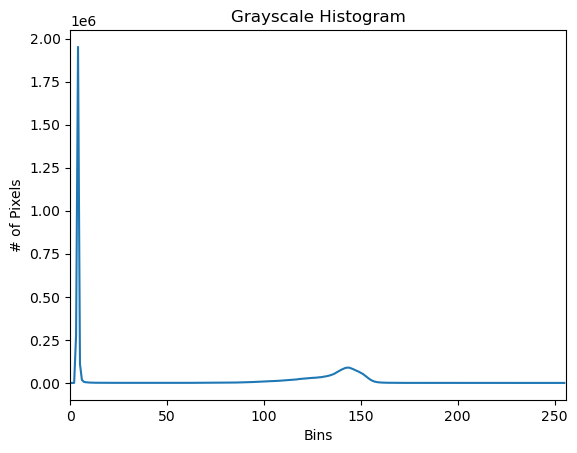

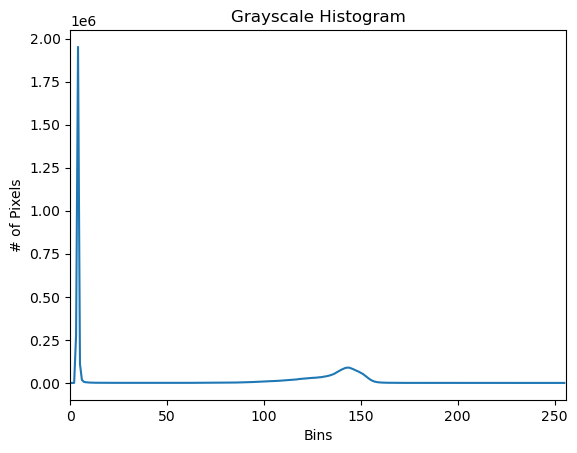

In [ ]:
import matplotlib.pyplot as plt

hist_1 = cv.calcHist([img1_g], [0], None, [256], [0, 256])
hist_2 = cv.calcHist([img2_g], [0], None, [256], [0, 256])


# plot the histogram
print(np.amax(img1_g))
print(np.amax(img1_g))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist_1)
plt.xlim([0, 256])
plt.show()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist_1)
plt.xlim([0, 256])
plt.show()

In [ ]:
arr = np.array([0, 100, 200, 255]).astype(np.uint8)
arr2 = arr.copy()
print(arr + arr2)
print((arr + arr2)/2)
print(arr.astype(np.uint16) + arr2)
print(arr.astype(np.uint16) + arr2.astype(np.uint16))
print((arr.astype(np.uint16) + arr2.astype(np.uint16)).astype(np.uint8))
print()

[  0 200 144 254]
[  0. 100.  72. 127.]
[  0 200 400 510]
[  0 200 400 510]
[  0 200 144 254]



In [ ]:
import numpy as np


def generatePeakBias(shape, peak_coordinates):
    f = 2.5 # TODO: optimize this constant, distance penalty factor
    
    
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    distances = np.sqrt((x - peak_coordinates[0])**2 + (y - peak_coordinates[1])**2)
    s = np.full(shape, np.amax(distances))
    distances = np.exp(-f*(distances/s)**2)
    return distances



bias = generatePeakBias([10, 7], (2, 1))
print(bias.shape)
print(bias)



(10, 7)
[[0.85534533 0.93941306 0.96923323 0.93941306 0.85534533 0.73161563
  0.58786967]
 [0.8824969  0.96923323 1.         0.96923323 0.8824969  0.7548396
  0.60653066]
 [0.85534533 0.93941306 0.96923323 0.93941306 0.85534533 0.73161563
  0.58786967]
 [0.77880078 0.85534533 0.8824969  0.85534533 0.77880078 0.66614361
  0.53526143]
 [0.66614361 0.73161563 0.7548396  0.73161563 0.66614361 0.56978282
  0.45783336]
 [0.53526143 0.58786967 0.60653066 0.58786967 0.53526143 0.45783336
  0.36787944]
 [0.40403652 0.44374731 0.45783336 0.44374731 0.40403652 0.34559075
  0.27768997]
 [0.2865048  0.31466396 0.32465247 0.31466396 0.2865048  0.24506054
  0.19691168]
 [0.19085334 0.20961139 0.21626517 0.20961139 0.19085334 0.16324551
  0.13117145]
 [0.11943297 0.13117145 0.13533528 0.13117145 0.11943297 0.10215643
  0.082085  ]]
